In [47]:
import pandas as pd
import os
import glob
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from jupyterthemes import jtplot
import pickle

# import requests
# from bs4 import BeautifulSoup
import git

jtplot.style()

If the cell above gives any errors for missing packages, simply:
`!pip install PACKAGE`,

where `PACKAGE` is the missing package, e.g. for git: it's 

`!pip install GitPython`

# Update data

check remote git:
    
`git remote show origin`

In [46]:
git_dir = r'./COVID-19/'

g = git.cmd.Git(git_dir)
g.fetch()
g.pull()

'Already up to date.'

# Create the dataframe from the different files

In [4]:
ending = 'csv'
path_to_files = r'./COVID-19/csse_covid_19_data/csse_covid_19_time_series'

all_paths = glob.glob(os.path.join(path_to_files, f'*.{ending}'))

In [5]:
all_paths

['./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv']

In [6]:
df_list = list()

for f in all_paths:
    foo = pd.read_csv(f)
    foo = pd.melt(foo, id_vars=[
                  'Province/State', 'Country/Region', 'Lat', 'Long'], var_name=['Date'])
    foo['Date'] = pd.to_datetime(foo['Date'])
    foo.columns = foo.columns.str.replace(
        'value', f.split("-")[-1].split(".")[0])
    foo['Province/State'].fillna(foo['Country/Region'], inplace=True)
    foo.set_index(['Province/State', 'Country/Region',
                   'Date', 'Lat', 'Long'], inplace=True)
    df_list.append(foo)

In [7]:
df = pd.concat(df_list, axis = 1).reset_index()
df.shape

(23426, 8)

In [ ]:
# europe = dict()

# URL = "https://en.wikipedia.org/wiki/Member_state_of_the_European_Union"

# res = requests.get(URL).text
# soup = BeautifulSoup(res,'lxml')
# for items in soup.find('table', class_='wikitable').find_all('tr')[1::1]:
#     data = items.find_all(['th','td'])
#     try:
#         country = data[0].a.text
#         europe[country] = 'EU'
#     except IndexError:
#         pass

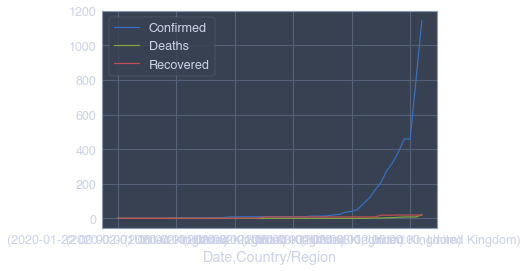

In [8]:
df[df['Country/Region'] == 'United Kingdom'].groupby(
    ['Date', 'Country/Region']).sum()[['Confirmed', 'Deaths', 'Recovered']].plot()

In [48]:
# Save to pickle

with open('country_continent.pickle', 'wb') as handle:
    pickle.dump(country_continent, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Read pickle
with open('country_continent.pickle', 'rb') as handle:
    country_continent = pickle.load(handle)

In [10]:
df2 = df.copy()
df2['Date_1'] = df2['Date'] + pd.Timedelta(days=1)
df2.rename(columns={'Confirmed': 'Confrimed_1',
                    'Deaths': 'Deaths_1',
                    'Recovered': 'Recovered_1',
                    'Date': 'Date_Minus_1'}, inplace=True)

In [11]:
df3 = df.merge(df2[['Province/State',
                    'Country/Region',
                    'Confrimed_1',
                    'Deaths_1',
                    'Recovered_1',
                    'Date_1',
                    'Date_Minus_1']], how='left',
               left_on=['Province/State', 'Country/Region', 'Date'],
               right_on=['Province/State', 'Country/Region', 'Date_1'])

In [12]:
df3['ConfirmedDaily'] = df3['Confirmed'] - df3['Confrimed_1']
df3['DeathsDaily'] = df3['Deaths'] - df3['Deaths_1']
df3['RecoveredDaily'] = df3['Recovered'] - df3['Recovered_1']

In [13]:
df3['ConfirmedDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Confirmed']
df3['DeathsDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Deaths']
df3['RecoveredDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Recovered']

del df3['Confrimed_1']
del df3['Deaths_1']
del df3['Recovered_1']
del df3['Date_1']
del df3['Date_Minus_1']

/Users/Arapidis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
df3.DeathsDaily.sum(), df3.ConfirmedDaily.sum(), df3.RecoveredDaily.sum()

(5819.0, 156102.0, 72624.0)

In [15]:
df3['MonthYear'] = df3['Date'].dt.strftime('%b-%Y')

In [16]:
df3['Continent'] = df3['Country/Region'].map(country_continent)

In [17]:
if len(df3[df3['Continent'].isna()]) == 0:
    print('All good')

All good


In [18]:
df3['DeathRate'] = df3['Deaths'] / df3['Confirmed']
df3['RecoveredRate'] = df3['Recovered'] / df3['Confirmed']

In [19]:
df3.head()

,Province/State,Country/Region,Date,Lat,Long,Recovered,Deaths,Confirmed,ConfirmedDaily,DeathsDaily,RecoveredDaily,MonthYear,Continent,DeathRate,RecoveredRate
0,"Adams, IN",US,2020-01-22,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN
1,"Adams, IN",US,2020-01-23,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN
2,"Adams, IN",US,2020-01-24,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN
3,"Adams, IN",US,2020-01-25,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN
4,"Adams, IN",US,2020-01-26,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN


# Plots

North America US


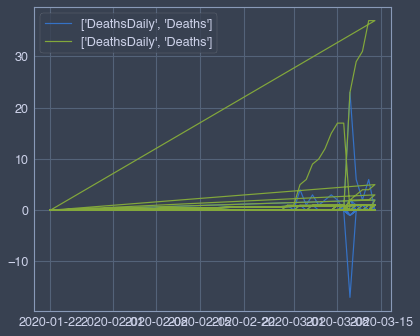

In [62]:
values = ['DeathsDaily', 'Deaths']
foo = pd.DataFrame()
bar = pd.DataFrame()
for cont in df3['Continent'].unique():
    foo = df3[df3['Continent'] == cont]
    for coun in foo['Country/Region'].unique():
        print(cont, coun)
        bar = foo[foo['Country/Region'] == coun]
        x = bar['Date']
        y = bar[values]
        plt.plot(x, y, label = values)
        plt.legend()
        break
    break
plt.show()
        #print(c)
        

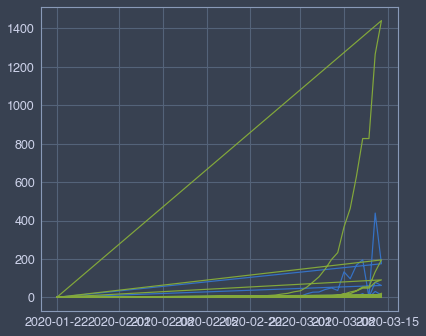

In [49]:
values = ['DeathsDaily', 'Deaths']
c = 'Europe'
d = 'Greece'
foo = df3[df3['Continent'] == c]
x = foo.groupby(['Country/Region', 'Date']).sum().reset_index()['Date']
y = foo.groupby(['Country/Region', 'Date']).sum().reset_index()[values]
plt.plot(x, y)
plt.show()

In [ ]:
for cnt in 

In [45]:
foo.groupby(['Country/Region', 'Date']).sum().reset_index()

,Country/Region,Date,Lat,Long,Recovered,Deaths,Confirmed,ConfirmedDaily,DeathsDaily,RecoveredDaily,DeathRate,RecoveredRate
0,Antigua and Barbuda,2020-01-22,17.0608,-61.7964,0,0,0,0.0,0.0,0.0,0.000000,0.000000
1,Antigua and Barbuda,2020-01-23,17.0608,-61.7964,0,0,0,0.0,0.0,0.0,0.000000,0.000000
2,Antigua and Barbuda,2020-01-24,17.0608,-61.7964,0,0,0,0.0,0.0,0.0,0.000000,0.000000
3,Antigua and Barbuda,2020-01-25,17.0608,-61.7964,0,0,0,0.0,0.0,0.0,0.000000,0.000000
4,Antigua and Barbuda,2020-01-26,17.0608,-61.7964,0,0,0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1002,US,2020-03-10,9517.5591,-23096.6146,8,28,959,376.0,6.0,1.0,0.300031,0.695170
1003,US,2020-03-11,9517.5591,-23096.6146,8,36,1281,322.0,8.0,0.0,0.336091,0.382336
1004,US,2020-03-12,9517.5591,-23096.6146,12,40,1663,382.0,4.0,4.0,0.337119,0.337282
1005,US,2020-03-13,9517.5591,-23096.6146,12,47,2179,516.0,7.0,0.0,0.502618,0.238388


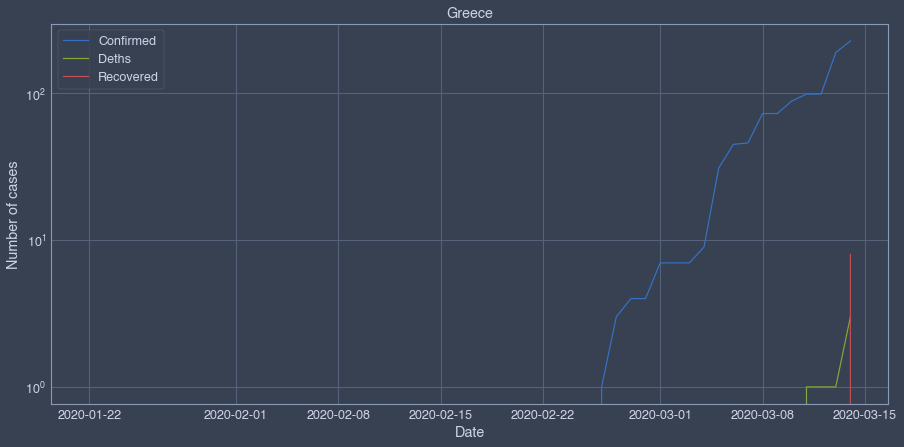

In [89]:
c = 'Greece'
x = df3[df3['Country/Region'] == c]['Date']
y1 = df3[df3['Country/Region'] == c]['Confirmed']
y2 = df3[df3['Country/Region'] == c]['Deaths']
y3 = df3[df3['Country/Region'] == c]['Recovered']

plt.figure(figsize = (15, 7))
plt.semilogy(x, y1, label = 'Confirmed')
plt.semilogy(x, y2, label = 'Deths')
plt.semilogy(x, y3, label = 'Recovered')
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title(c)
plt.legend()
plt.show()

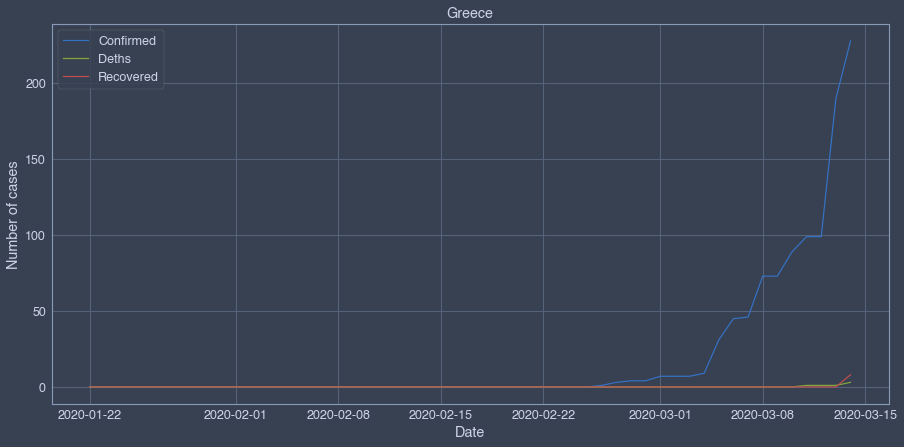

In [94]:
c = 'Greece'
x = df3[df3['Country/Region'] == c]['Date']
y1 = df3[df3['Country/Region'] == c]['Confirmed']
y2 = df3[df3['Country/Region'] == c]['Deaths']
y3 = df3[df3['Country/Region'] == c]['Recovered']

plt.figure(figsize = (15, 7))
plt.plot(x, y1, label = 'Confirmed')
plt.plot(x, y2, label = 'Deths')
plt.plot(x, y3, label = 'Recovered')
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title(c)
plt.legend()
plt.show()

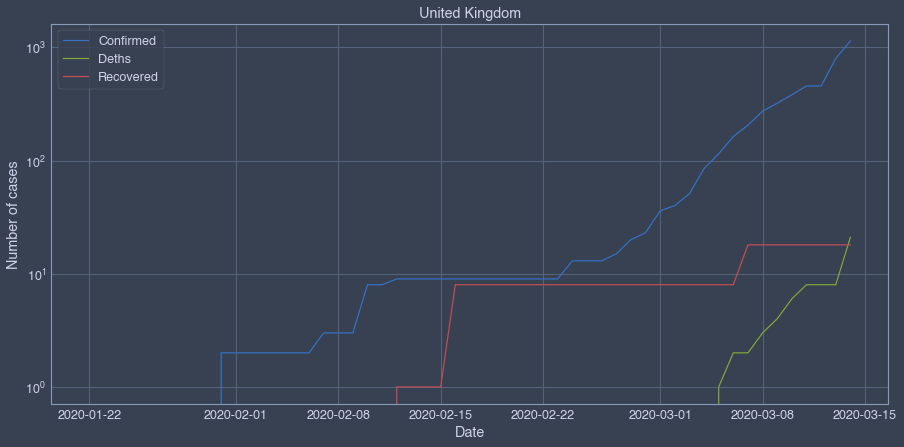

In [91]:
c = 'United Kingdom'
x = df3[df3['Province/State'] == c]['Date']
y1 = df3[df3['Province/State'] == c]['Confirmed']
y2 = df3[df3['Province/State'] == c]['Deaths']
y3 = df3[df3['Province/State'] == c]['Recovered']

plt.figure(figsize = (15, 7))
plt.semilogy(x, y1, label = 'Confirmed')
plt.semilogy(x, y2, label = 'Deths')
plt.semilogy(x, y3, label = 'Recovered')
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title(c)
plt.legend()
plt.show()

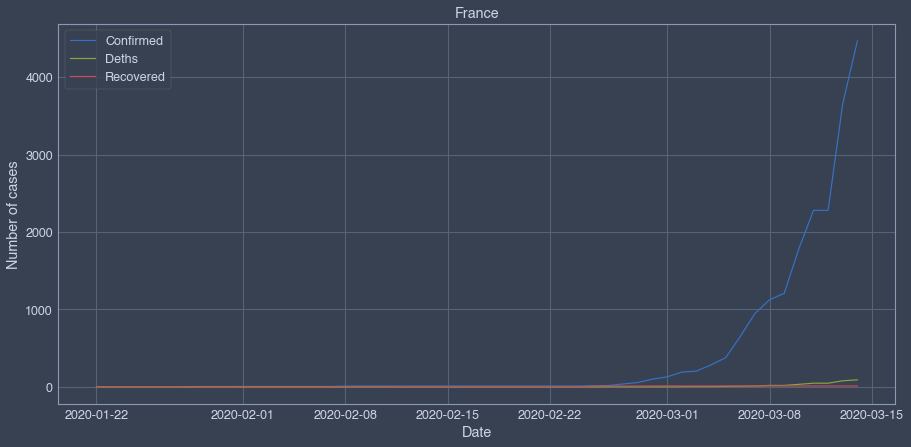

In [95]:
c = 'France'
x = df3[df3['Province/State'] == c]['Date']
y1 = df3[df3['Province/State'] == c]['Confirmed']
y2 = df3[df3['Province/State'] == c]['Deaths']
y3 = df3[df3['Province/State'] == c]['Recovered']

plt.figure(figsize = (15, 7))
plt.plot(x, y1, label = 'Confirmed')
plt.plot(x, y2, label = 'Deths')
plt.plot(x, y3, label = 'Recovered')
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title(c)
plt.legend()
plt.show()

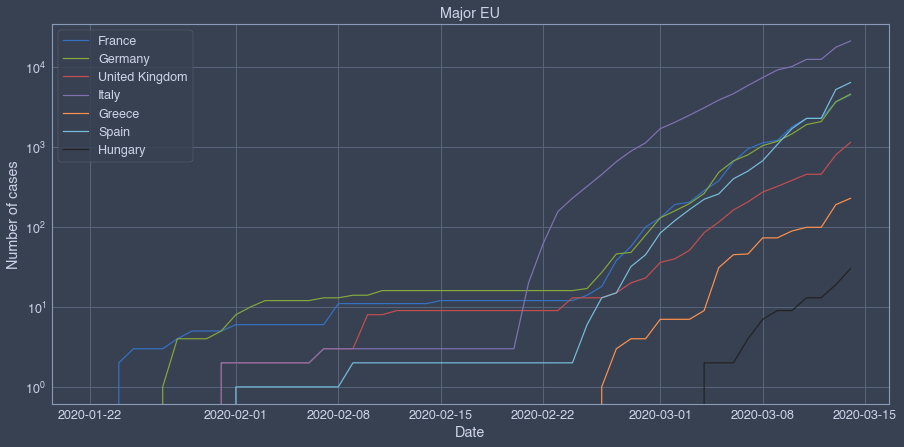

In [108]:

x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['Confirmed']
y2 = df3[df3['Province/State'] == 'Germany']['Confirmed']
y3 = df3[df3['Province/State'] == 'United Kingdom']['Confirmed']
y4 = df3[df3['Province/State'] == 'Italy']['Confirmed']
y5 = df3[df3['Province/State'] == 'Greece']['Confirmed']
y6 = df3[df3['Province/State'] == 'Spain']['Confirmed']
y7 = df3[df3['Province/State'] == 'Hungary']['Confirmed']




plt.figure(figsize = (15, 7))
plt.semilogy(x, y1, label = 'France')
plt.semilogy(x, y2, label = 'Germany')
plt.semilogy(x, y3, label = 'United Kingdom')
plt.semilogy(x, y4, label = 'Italy')
plt.semilogy(x, y5, label = 'Greece')
plt.semilogy(x, y6, label = 'Spain')
plt.semilogy(x, y7, label = 'Hungary')

plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title('Major EU')
plt.legend()
plt.show()

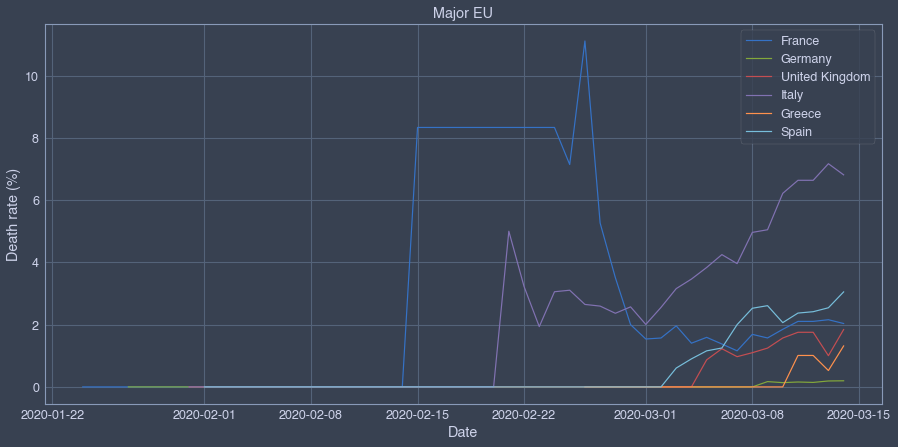

In [104]:

x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['DeathRate'] * 100
y2 = df3[df3['Province/State'] == 'Germany']['DeathRate'] * 100
y3 = df3[df3['Province/State'] == 'United Kingdom']['DeathRate'] * 100
y4 = df3[df3['Province/State'] == 'Italy']['DeathRate'] * 100
y5 = df3[df3['Province/State'] == 'Greece']['DeathRate'] * 100
y6 = df3[df3['Province/State'] == 'Spain']['DeathRate'] * 100




plt.figure(figsize = (15, 7))
plt.plot(x, y1, label = 'France')
plt.plot(x, y2, label = 'Germany')
plt.plot(x, y3, label = 'United Kingdom')
plt.plot(x, y4, label = 'Italy')
plt.plot(x, y5, label = 'Greece')
plt.plot(x, y6, label = 'Spain')

plt.ylabel('Death rate (%)')
plt.xlabel('Date')
plt.title('Major EU')
plt.legend()
plt.show()

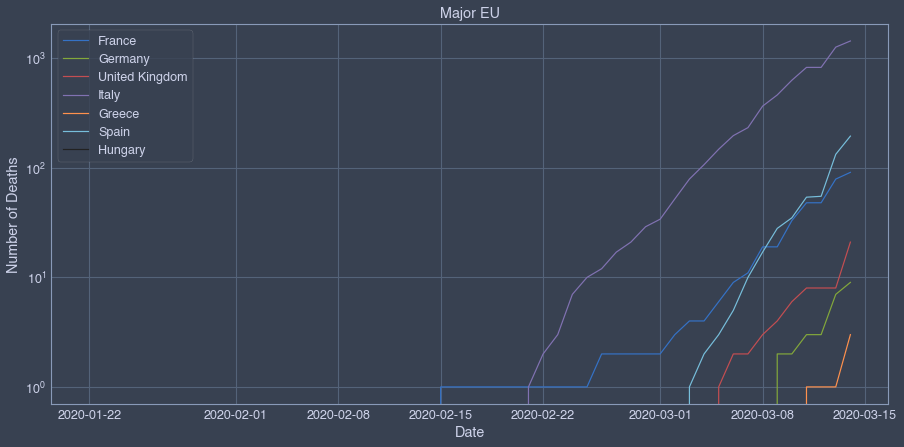

In [106]:

x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['Deaths']
y2 = df3[df3['Province/State'] == 'Germany']['Deaths']
y3 = df3[df3['Province/State'] == 'United Kingdom']['Deaths']
y4 = df3[df3['Province/State'] == 'Italy']['Deaths']
y5 = df3[df3['Province/State'] == 'Greece']['Deaths']
y6 = df3[df3['Province/State'] == 'Spain']['Deaths']
y7 = df3[df3['Province/State'] == 'Hungary']['Deaths']




plt.figure(figsize = (15, 7))
plt.semilogy(x, y1, label = 'France')
plt.semilogy(x, y2, label = 'Germany')
plt.semilogy(x, y3, label = 'United Kingdom')
plt.semilogy(x, y4, label = 'Italy')
plt.semilogy(x, y5, label = 'Greece')
plt.semilogy(x, y6, label = 'Spain')
plt.semilogy(x, y7, label = 'Hungary')

plt.ylabel('Number of Deaths')
plt.xlabel('Date')
plt.title('Major EU')
plt.legend()
plt.show()

In [20]:
df3.to_csv('data_v0.4.csv')

In [41]:
foo.groupby(['Country/Region', 'Date']).sum()[values]


DeathsDaily  Deaths
Country/Region      Date                           
Antigua and Barbuda 2020-01-22          0.0       0
                    2020-01-23          0.0       0
                    2020-01-24          0.0       0
                    2020-01-25          0.0       0
                    2020-01-26          0.0       0
...                                     ...     ...
US                  2020-03-10          6.0      28
                    2020-03-11          8.0      36
                    2020-03-12          4.0      40
                    2020-03-13          7.0      47
                    2020-03-14          7.0      54

[1007 rows x 2 columns]